# Exam project: The remote labour market in Denmark

This notebook is used for webscraping www.jobindex.dk for job postings in the period 2010-2020. 

In [328]:
# Import necessary modules
import re
import requests
import numpy as np
import pandas as pd
import math
import time
from bs4 import BeautifulSoup
from datetime import datetime
import PyPDF2 
import textract
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import slate3k as slate
import certifi #pip install certifi
import urllib3 #pip install urllib3[secure]
http = urllib3.PoolManager()
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import langdetect 
import nltk
from langdetect import detect #pip install langdetect

#Make log
import scraping_class
logfile = 'log_jobindex_scraping.txt'
connector = scraping_class.Connector(logfile)

#Define todays date and enddate for data
from datetime import date
today = date.today().strftime("%Y%m%d") # to get format 20080101
start = '20100101'

#Define path to folder
path = (r'C:\Users\miche\Dropbox\KU Introduction to Social Data Science\Modules')

### Web-scraping job postings from Jobindex
##### Geographical region and job category
www.jobindex.dk/jobsoegning has filters for geographical area and job category, respectively. We will scrape this to be able to describe in which areas and industries remote working is especially taking place. 
The address of the company is also attached to the job posting, and even though this information would be more detailed, we have experienced that the address often belongs to the headquarter of the company and not the specific area, where the job is. Therefore we use the information from the geographical filter.

In [329]:
#Define the basic url
url = 'https://www.jobindex.dk/jobsoegning'
response = requests.get(url)
html = response.text
soup = BeautifulSoup(html,'lxml')

#Areas are given in the html by div id=areas and class=area_label
areas_html = soup.find('div', {'id':'areas'})#('a', {'class':'area_label'})
areas_div = str(areas_html).split('href="/jobsoegning/')[1:]

#Find the names of each of the areas
areas = () #we make a tuple, so we can order it
areas_delete = ('skaane', 'faeroeerne', 'udlandet', 'groenland', 'danmark') #delete regions outside Denmark's borders
for area in areas_div:
    link = area.split('"')[0]
    if link in areas_delete:
        del link
    else:
        areas += (link,)
areas += ('danmark',) #make sure Danmark is the last element in the tuple. 
#print(areas)

#Categories are given in the html by and id=categories
cat_html = soup.find('div', {'id':'categories'})
cat_div = soup.find_all('a',{'class':'filter-section-header title collapsed'}) #the filter collapses

categories = []
subcategories = []
for cat in cat_div:
    #first find the overall categories
    cat_name = re.findall(r'(?<=<span>)(.*)(?=<span class)', str(cat))[0]
    cat_name = cat_name.replace('\xad','')
    cat_links = re.findall("href=[\"\'](.*?)[\"\']", str(cat))
    cat_id = str(cat_links[0])
    cat_id = cat_id.replace('#','')
    category = [cat_name,cat_id]
    categories.append(category)
    #next find the sub-categories
    subcat_div = str(cat_html).split('href="/jobsoegning/')[1:]
for subcat in subcat_div:
    subcategory = subcat.split('"')[0]
    subcategories.append(subcategory)
#print(categories)
#print(subcategories)

##### Defining "remote job postings"
We define a string of words and phrases related to working remotely to search through Jobindex for remote job postings. We include both Danish and English words/phrases, as we have experienced a lot of English job postings in bigger companies.
We started out by trying to webscrape all job postings over the period and would have labeled remote/not remote afterwards, however there was approx. 3 million job postings and the scraping would take days. Instead we scrape the details of the relevant job postings and scrape the sum of the rest to be able to report relative numbers (although they are not perfect).

##### Number of postings and pages
Each page of www.jobindex.dk/jobsoegning contains 20 joblistings. Since the number of job postings differ from time to time, so does the number of pages. To be able to scrape job postings on all pages, we look at the pagination and find the max page.

In [92]:
#Define the search words in jobindex for working remotely
remotely = ['hjemmekontor','hjemmearbejde','fjernarbejde','arbejde%2Bhjemmefra','arbejde%2Bhjemme','remote%2Barbejdsplads','remote%2Bwork','work%2Bremotely', 'working%2Bremotely','working%2Bfrom%2Bhome', 'home%2Boffice','home-office']

#Scraping in loops from jobindex.
jobs = []
for area in areas:
    for subcategory in subcategories:
        print('Now requesting url: ' + subcategory +' and '+ area)
        for remote in remotely:
            url = f'https://www.jobindex.dk/jobsoegning/{subcategory}/{area}?jobage=archive&maxdate={today}&mindate={start}&q={remote}'
            response = requests.get(url) 
            soup = BeautifulSoup(response.text,'lxml')
        
            #Identify total number of job postings in the given quarter
            pages = BeautifulSoup(str(soup.find_all("div", {'class':'jix_pagination_total'}))).get_text() 
            total = re.findall(r'af(?s)(.*)resultat',str(pages))
            total = str(total).strip("[]").strip("''").strip().replace('.','')
            if total == 0:
                continue
            #Use total number of job postings to calculate total number of pages
            last_page = math.ceil(int(total)/20)
        
            #Loop through pages
            for page in range(1,last_page+1):
                if  page % 20 == 0:
                    print('Now scraping page: ',page,'/', last_page, ' for ', subcategory, ' and ', area)
                url = f'https://www.jobindex.dk/jobsoegning/{subcategory}/{area}?jobage=archive&maxdate={today}&mindate={start}&page={page}&q={remote}'
                response = requests.get(url)  
                html = response.text   
                if '<strong>' in html: 
                    html = html.replace('<strong>','<b>')\
                                .replace('</strong>','</b>')
                else:
                    print('No <strong>')
                soup = BeautifulSoup(html,'lxml') 
                joblistings = soup.find_all('div',{'class':'jobsearch-result'}) 
                        
                for joblisting in joblistings: #Loop through job listings
                    #Find title
                    title = re.findall(r'(?<=<b>)(.*)(?=</b>)', str(joblisting))[0]
                    title = title.replace('amp;','')
                    #Find company name
                    if len(re.findall(r'(?<=<b>)(.*)(?=</b>)', str(joblisting)))>1:
                        company = re.findall(r'(?<=<b>)(.*)(?=</b>)', str(joblisting))[1]
                        company = company.replace('amp;','')\
                                            .replace('<b>','')\
                                            .replace('</b>','') 
                    #Find publication date
                    pub_date = re.findall(r'time\sdatetime="(.*)"', str(joblisting))[0]
                    geo_area = area #Save geographical area
                    cat_id = re.findall('(.*?)/', str(subcategory))[0] #Save category 
                    subcat_id = subcategory #Save subcategory
                    remote_word = remote
                    #Find link to job posting
                    descrip = BeautifulSoup(str(joblisting), 'lxml')
                    for div in descrip.find_all("div", {'class':'jix_toolbar jix_appetizer_toolbar'}): # remove toolbar at the end of each job
                        div.decompose()
                    for span in descrip.find_all("span", {'class':'jix_toolbar jix_appetizer_toolbar'}): # remove toolbar at the end of each job
                        span.decompose()
                    links = re.findall("href=[\"\'](.*?)[\"\']", str(descrip))
                    if len(links)>1:
                        link = str(links[1])
                    else:
                        link = str(links[0])
                    link = link.replace("&amp;", "&")
                    # Indirectly extracting the short job description by removing everything else
                    descrip = descrip.get_text()
                    descrip = descrip.replace("\n", " ") # remove \n
                    job = [title, company, pub_date, remote_word, geo_area, cat_id, subcat_id, link, descrip]
                    jobs.append(job)
    df = pd.DataFrame(jobs)
    df.columns = ['Job Title','Company','Publication Date','Remote word','Geographical Area','Job Category','Job Subcategory', 'Link', 'Description']
    df.to_pickle(path+'\Jobs_basic_info_10-20')
    print('Finished area: ',area)
 

Now requesting url: it/database and sydjylland
Now requesting url: it/itdrift and sydjylland
Now requesting url: it/itkurser and sydjylland
Now requesting url: it/itledelse and sydjylland
Now requesting url: it/internet and sydjylland
Now requesting url: it/systemudvikling and sydjylland
Now requesting url: it/telekom and sydjylland
Now requesting url: it/virksomhedssystemer and sydjylland
Now requesting url: ingenioer/byggeteknik and sydjylland
Now requesting url: ingenioer/elektronik and sydjylland
Now requesting url: ingenioer/kemi and sydjylland
Now requesting url: ingenioer/teknikledelse and sydjylland
Now requesting url: ingenioer/maskiningenioer and sydjylland
Now requesting url: ingenioer/medicinal and sydjylland
Now requesting url: ingenioer/produktionsteknik and sydjylland
Now requesting url: ledelse/detailledelse and sydjylland
Now requesting url: ledelse/freelancekonsulent and sydjylland
Now requesting url: ledelse/hrkurser and sydjylland
Now requesting url: it/itledelse an

Now requesting url: industri/toemrer and bornholm
Now requesting url: salg/design and bornholm
Now requesting url: salg/ejendomsmaegler and bornholm
Now requesting url: salg/grafisk and bornholm
Now requesting url: salg/kommunikation and bornholm
Now requesting url: salg/kultur and bornholm
Now requesting url: salg/marketing and bornholm
Now requesting url: salg/salg and bornholm
Now requesting url: salg/salgskurser and bornholm
Now requesting url: ledelse/salgschef and bornholm
Now requesting url: salg/franchise and bornholm
Now requesting url: salg/telemarketing and bornholm
Now requesting url: undervisning/bibliotek and bornholm
Now requesting url: undervisning/forskning and bornholm
Now requesting url: ledelse/institutions and bornholm
Now requesting url: undervisning/laerer and bornholm
Now requesting url: undervisning/paedagog and bornholm
Now requesting url: undervisning/voksenuddannelse and bornholm
Now requesting url: kontor/akademisk and bornholm
Now requesting url: salg/ejen

Now scraping page:  40 / 57  for  oevrige/student  and  danmark
Now requesting url: oevrige/studiepraktik and danmark
Now requesting url: oevrige/oevrige and danmark
Now requesting url: oevrige/kurseroevrige and danmark
Finished area:  danmark


In [10]:
'''import PyPDF2 
import textract
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import slate3k as slate
import pandas as pd

jobindex_links = []
for i in range(1,3): # NOTE I'm only testing it on the first two pages. Use last_page when ready
    url = f'https://www.jobindex.dk/jobsoegning?lang=da?page={i}.html'
    jobindex_links.append(url)   
#print(jobindex_links)
html = []
job_links = []
jobs = []
dates = []

for url in jobindex_links:
    response = requests.get(url)  
    html = response.text  
    soup = BeautifulSoup(html,'lxml')
    #one job result is given by class=jobsearch-result
    joblistings = soup.find_all('div',{'class':'jobsearch-result'})
    #print(joblistings)
    for joblisting in joblistings:
        title = re.findall(r'(?<=<b>)(.*)(?=</b>)', str(joblisting))[0]
        links = re.findall("href=[\"\'](.*?)[\"\']", str(joblisting))
        link = str(links[1])
        link = link.replace("&amp;", "&")
        pub_date = re.findall(r'time\sdatetime="(.*)"', str(joblisting))
        dates.append(pub_date) 
        job = [title,link,pub_date]
        jobs.append(job) # Jobs is a list of list where each list contains the title job, and the link for that job, this will help later
        job_links.append(link)

for i in range(len(job_links)):
    if 'pdf' in jobs[i][1]:
        #scraping a PDF file
        #request the url
        url = jobs[i][1]
        response = requests.get(url)
        #save the pdf in the current folder
        with open('pdf.pdf', 'wb') as f:
            f.write(response.content)
        #open the pdf and get the text in doc
        with open('pdf.pdf', 'rb') as fp:
            doc = slate.PDF(fp)
            doc = str(doc).replace('\n','')
            doc = str(doc).replace('\r','')
            jobs[i].append(doc)
    else:
        link = jobs[i][1]
        response = requests.get(link)
        html = response.text
        soup = BeautifulSoup(html, 'lxml')
        description = soup.get_text()
        description = description.replace('\n','')
        description = description.replace('\r','')
        jobs[i].append(description)
    
    print('Completed %d/%d job_links' % (i,len(job_links)))

#transforming into dataframe
df = pd.DataFrame(jobs)
df.columns = ["Job Title", "Link","Date", "Description",]'''


Completed 0/40 job_links
Completed 1/40 job_links
Completed 2/40 job_links
Completed 3/40 job_links
Completed 4/40 job_links
Completed 5/40 job_links
Completed 6/40 job_links
Completed 7/40 job_links
Completed 8/40 job_links
Completed 9/40 job_links
Completed 10/40 job_links
Completed 11/40 job_links
Completed 12/40 job_links
Completed 13/40 job_links
Completed 14/40 job_links
Completed 15/40 job_links
Completed 16/40 job_links
Completed 17/40 job_links
Completed 18/40 job_links
Completed 19/40 job_links
Completed 20/40 job_links
Completed 21/40 job_links
Completed 22/40 job_links
Completed 23/40 job_links
Completed 24/40 job_links
Completed 25/40 job_links
Completed 26/40 job_links
Completed 27/40 job_links
Completed 28/40 job_links
Completed 29/40 job_links
Completed 30/40 job_links
Completed 31/40 job_links
Completed 32/40 job_links
Completed 33/40 job_links
Completed 34/40 job_links
Completed 35/40 job_links
Completed 36/40 job_links
Completed 37/40 job_links
Completed 38/40 job_li

### Cleaning the data for final dataset
We clean the data for duplicate observations from scraping url's, that may contain some of the same job postings. It is done in steps to be able to report the proces in our paper.


In [330]:
#Read the three datafiles scraped from Jobindex
unpickled1 = pd.read_pickle(path+'\Jobs_basic_info')
unpickled2 = pd.read_pickle(path+'\Jobs_basic_info_10rest') 
unpickled3 = pd.read_pickle(path+'\Jobs_basic_info_10rest2')
unpickled_df = pd.concat([unpickled1,unpickled2,unpickled3])
#print(unpickled_df.columns)
print('Length of dataset: ',len(unpickled_df)) 

#Change variables
unpickled_df['Remote'] = 1
unpickled_df['Publication Date'] = pd.to_datetime(unpickled_df['Publication Date'], format='%Y-%m-%d').dt.to_period('M')
unpickled_df['Year'] = unpickled_df['Publication Date'].dt.strftime('%Y')
unpickled_df['Date'] = unpickled_df['Publication Date'].dt.strftime('%Y%m%d')
unpickled_df['Month-Year'] = unpickled_df['Publication Date'].dt.strftime('%b-%Y')

#Report how many obs in each [remote word] for data description
count_remote_word = pd.DataFrame(unpickled_df.groupby('Remote word')['Remote'].sum()).reset_index()
print(count_remote_word)   

#Removing duplicated step by step
#Dropping completely duplicte entries 
dupl1 = unpickled_df.drop_duplicates(keep = 'first')
print('Length after dropping all complete duplicates: ', len(dupl1))

#Drop duplicate entries based on all columns besides remote word (=> same job posting could occur in multiple searchings)
dupl2 = dupl1.drop_duplicates(subset=['Job Title','Company','Publication Date','Geographical Area','Job Category','Job Subcategory','Link','Description'], keep = 'first')
print('Length after dropping duplicates on remote word: ',len(dupl2))

#Drop duplicate entries based on all columns besides category and subcategory (=> same job could occur in more categories)
dupl3 = dupl2.drop_duplicates(subset=['Job Title','Company','Publication Date','Geographical Area','Link','Description'], keep = 'first')
print('Length after dropping duplicates on category and subcategory: ',len(dupl3))

#Drop duplicate entries based on all columns besides remote word and geographical area (=> same job could occur)
#Be aware that the same job posting can be in more areas
dupl4 = dupl3.drop_duplicates(subset=['Job Title','Company','Publication Date','Link','Description'], keep = 'first')
print('Length after dropping duplicates on geographical area: ',len(dupl4))

######FINAL DATA###########################################################################################
final_data = dupl4.copy()

#Save final data frame
#final_data.to_pickle(path + '\final_data.pkl')
#final_data.to_csv(path +'\final_data.csv')
############################################################################################################

Length of dataset:  54281
              Remote word  Remote
0        arbejde%2Bhjemme    3688
1     arbejde%2Bhjemmefra   15462
2            fjernarbejde      90
3           hjemmearbejde    4882
4            hjemmekontor   16370
5           home%2Boffice    4190
6             home-office    4190
7   remote%2Barbejdsplads      29
8           remote%2Bwork    1119
9         work%2Bremotely    1065
10  working%2Bfrom%2Bhome    2564
11     working%2Bremotely     632
Length after dropping all complete duplicates:  52193
Length after dropping duplicates on remote word:  47117
Length after dropping duplicates on category and subcategory:  36119
Length after dropping duplicates on geographical area:  14717


## Assigning DISCO-08 codes to the job postings
This function will be used to assign a DISCO-08 code to the job postings. It goes through the following steps:

1. Importing a csv file downloaded from Danmarks Statistik which includes the different job functions that fall under each DISCO-08 category
2. Clean this csv file and converting it into a dataframe with two columns, one that has the disco codes and one that has a list of all the jobs that fall into each code
3. Tokenizing the jobs 
4. Tokenizing the words in the 'Job Title' column from our job postings data
5. Creating a function that compares the tokens in the job titles to the tokens in the DISCO dataframe and if a match is found, then returning the corresponding DISCO code

In [319]:
# Importing and cleaning DISCO-08 classification

disco = pd.read_csv(r"C:\Users\lisbe\OneDrive\11. Semester\Social Data Science\Modules\csv_da.csv",header=None)
disco_clean = disco.copy()

# Remove words that start with lowercase
for i in range(len(disco_clean)):
    disco_clean[3][i] = ' '.join([word for word in str(disco_clean[3][i]).split(' ') if not word.islower()])

# Create a dictionary for DISCO functions

disco_clean['DISCO'] = disco_clean[0].astype(str).str[:1] #This column will have the highest hierarchy code 0-9
del disco_clean[0]
del disco_clean[1]
del disco_clean[2]
disco_clean = disco_clean.groupby(by=disco_clean['DISCO']).sum()
disco_clean.rename({3:'functions'}, axis='columns', inplace = True) # rename column 
for i in range(9): # Adding a space in between words that are missing them "LikeThis"
    disco_clean['DISCO'] = disco_clean['DISCO'].astype(str).str[:1] # We only want the first number 
    disco_clean['functions'][i] = re.sub(r"(\w)([A-Z])", r"\1 \2", str(disco_clean['functions'][i]))
    
disco_clean["functions_tokenized"] = ""
for i in range(len(disco_clean)):
    disco_clean['functions_tokenized'][i]=nltk.word_tokenize(str(disco_clean['functions'][i]).lower())
    
# Now I would like a job type column from the job titles where I would extract the nouns from job titles
#pip install afinn
import nltk
df['Job Title']=df['Job Title'].str.replace(',','')
df["tokenized_titles"] = ""
for i in range(len(df)):
    df['tokenized_titles'][i] = nltk.word_tokenize(str(df['Job Title'][i]).lower())

# This loop creates a new column in the df that assigns a disco code to each posting based on the words in the title

df['disco'] = ''
for m in range(len(df)):
    for i in range(len(disco_clean)):
        for element in disco_clean['functions_tokenized'][i]:
            if element in df['tokenized_titles'][m]:
                df['disco'][m] = disco_clean['DISCO'][i]

C:\Users\lisbe\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


## Scraping total number of job postings from Jobindex
Since we were not able to scrape the details of all job postings, because the scraping would have taken days to run, we have scraped the remote job postings with details and will scrape the total number of job postings on a given date to ba able to report relative numbers.
To get the least amount of duplicates, we scrape the total number of job postings on a given date/month alone, for each area and for each category.

1. First, we scrape the total number of jobs posted DAILY from 2010-2020
2. Second, we scrape the total number of jobs posted MONTHLY from 2010-2020 in each area
3. Third, we scrape the total number of jobs posted MONTHLY from 2010-2020 in each subcategory

In [3]:
#Define a list of daily dates from 2010 until today
datelist = pd.date_range(start=start, end=today, freq='D').date.tolist()
datelist = [str(date).strip("()").strip("datetime.date").replace(',','').replace('-','') for date in datelist]
print(datelist[1:10])

#Define the date lists of months from 2020 until today
start_date = pd.date_range(start,'2020-09-01', freq='1M')-pd.offsets.MonthBegin(1)
start_date = [str(date).strip("()").strip("datetime.date").replace(',','').replace('-','').replace(':','').strip(' 000000') for date in start_date]

end_date = pd.date_range(start,'2020-10-01', freq='1M')
end_date = [str(date).strip("()").strip("datetime.date").replace(',','').replace('-','').replace(':','').strip('000000').rstrip() for date in end_date]

def merge(list1, list2): 
    merged_list = tuple(zip(list1, list2))  
    return merged_list 
month_dates = merge(start_date,end_date)
print(month_dates[1:10])

['20100102', '20100103', '20100104', '20100105', '20100106', '20100107', '20100108', '20100109', '20100110']
(('20100201', '20100228'), ('20100301', '20100331'), ('20100401', '20100430'), ('20100501', '20100531'), ('20100601', '20100630'), ('20100701', '20100731'), ('20100801', '20100831'), ('20100901', '20100930'), ('20101001', '20101031'))


In [120]:
#Scrape total number of job postings posted on each date
date_totals = []
for date in datelist:
    print('Has now reached date: '+date)
    url = f'https://www.jobindex.dk/jobsoegning?maxdate={date}&mindate={date}&jobage=archive'
    response = requests.get(url) 
    soup = BeautifulSoup(response.text,'lxml')
    search_results = BeautifulSoup(str(soup.find_all("div", {'class':'jix_pagination_total'}))).get_text()
    total = re.findall(r'af(?s)(.*)resultat',str(search_results))
    total = str(total).strip("[]").strip("''").strip().replace('.','')
    if total == 0:
            continue
    #Use total number of job postings to calculate total number of pages
    total=int(total)
    t_d = [date,total]
    date_totals.append(t_d)
    
totals = pd.DataFrame(date_totals)
totals.columns = ['Date','Postings Published']
totals.to_pickle(path+'\Total_jobs_daily10-20.pkl')

['19691231', '19700101', '19700102', '19700103', '19700104', '19700105', '19700106', '19700107', '19700108', '19700109', '19700110', '19700111', '19700112', '19700113', '19700114', '19700115', '19700116', '19700117', '19700118', '19700119', '19700120', '19700121', '19700122', '19700123', '19700124', '19700125', '19700126', '19700127', '19700128', '19700129', '19700130', '19700131', '19700201', '19700202', '19700203', '19700204', '19700205', '19700206', '19700207', '19700208', '19700209', '19700210', '19700211', '19700212', '19700213', '19700214', '19700215', '19700216', '19700217', '19700218', '19700219', '19700220', '19700221', '19700222', '19700223', '19700224', '19700225', '19700226', '19700227', '19700228', '19700301', '19700302', '19700303', '19700304', '19700305', '19700306', '19700307', '19700308', '19700309', '19700310', '19700311', '19700312', '19700313', '19700314', '19700315', '19700316', '19700317', '19700318', '19700319', '19700320', '19700321', '19700322', '19700323', '19

'\n#Scrape total number of job postings posted on each date\ndate_totals = []\nfor date in datelist:\n    print(\'Has now reached date: \'+date)\n    url = f\'https://www.jobindex.dk/jobsoegning?maxdate={date}&mindate={date}&jobage=archive\'\n    response = requests.get(url) \n    soup = BeautifulSoup(response.text,\'lxml\')\n    search_results = BeautifulSoup(str(soup.find_all("div", {\'class\':\'jix_pagination_total\'}))).get_text()\n    total = re.findall(r\'af(?s)(.*)resultat\',str(search_results))\n    total = str(total).strip("[]").strip("\'\'").strip().replace(\'.\',\'\')\n    if total == 0:\n            continue\n    #Use total number of job postings to calculate total number of pages\n    total=int(total)\n    t_d = [date,total]\n    date_totals.append(t_d)\n    \ntotals = pd.DataFrame(date_totals)\ntotals.columns = [\'Date\',\'Postings Published\']\ntotals.to_pickle(path+\'\\Total_jobs_daily10-20.pkl\')'

In [ ]:
#Scrape total number of job postings each month for each area and category
date_totals_area = []
         
for area in areas:
    print('Has now reached area: '+area )
    for date in month_dates:
        url = f'https://www.jobindex.dk/jobsoegning/{area}?maxdate={date[1]}&mindate={date[0]}&jobage=archive'
        response = requests.get(url) 
        soup = BeautifulSoup(response.text,'lxml')
        search_results = BeautifulSoup(str(soup.find_all("div", {'class':'jix_pagination_total'}))).get_text()
        total = re.findall(r'af(?s)(.*)resultat',str(search_results))
        total = str(total).strip("[]").strip("''").strip().replace('.','')
        if total == 0:
                continue
        #Use total number of job postings to calculate total number of pages
        total=int(total)
        month = pd.date_range(date[0], date[1], freq='MS').strftime("%b-%Y").tolist()
        t_d = [month,area,total]
        date_totals_area.append(t_d)

totals_cat_area = pd.DataFrame(date_totals_area)
totals_cat_area.columns = ['Month-Year','Area','Postings Published']
totals_cat_area.to_pickle(path+'\Total_jobs_month_area10-20.pkl')

Has now reached area: storkoebenhavn
Has now reached area: nordsjaelland
Has now reached area: region-sjaelland


In [ ]:
#Scrape total number of job postings each month for each subcategory
date_totals_subcat = []

for subcategory in subcategories:
    print('Has now reached subcategory: '+subcategory)
    for date in month_dates:
        url = f'https://www.jobindex.dk/jobsoegning/{subcategory}?jobage=archive&maxdate={date[1]}&mindate={date[0]}'
        response = requests.get(url) 
        soup = BeautifulSoup(response.text,'lxml')
        search_results = BeautifulSoup(str(soup.find_all("div", {'class':'jix_pagination_total'}))).get_text()
        total = re.findall(r'af(?s)(.*)resultat',str(search_results))
        total = str(total).strip("[]").strip("''").strip().replace('.','')
        if total == 0:
                continue
        total=int(total)
        month = pd.date_range(date[0], date[1], freq='MS').strftime("%b-%Y").tolist()
        category = re.findall('(.*?)/', str(subcategory))[0]
        t_d = [month,category,subcategory,total]
        date_totals_subcat.append(t_d)
        
totals_subcat = pd.DataFrame(date_totals_subcat)
totals_subcat.columns = ['Month-Year','Job Category','Job Subcategory','Postings Published']
totals_subcat.to_pickle(path+'Total_jobs_month_subcategory10-20')
#totals_cats = pd.concat([totals_subcat, totals_cat]).drop_duplicates()

# Graphs for descriptive analysis
This part of the notebook prepares the dataframe for the different graphs and makes the graphs

First we make dataframes for different kind of data we need for the graphs.
We then make the different graphs and save them to put in the report.

In [284]:
#Make lists of dates, areas, categories and subcategories
#all unique dates
dates = pd.DataFrame(pd.date_range(start=start, end=today, freq='D').strftime("%Y%m%d").tolist())
dates = dates.iloc[pd.to_datetime(dates.index).argsort()] #sort
dates.columns = ['Date']

#all unique month-year
months = pd.DataFrame(pd.date_range(start=start, end=today, freq='MS').strftime("%b-%Y").tolist()) 
months = months.iloc[pd.to_datetime(months.index).argsort()] #sort
months.columns = ['Month-Year']
#monthlist = [str(date).strip("()").strip("datetime.date").replace(',','') for date in monthlist]

#all unique areas
areas = pd.DataFrame(np.unique(final_data['Geographical Area']))
areas.columns = ['Geographical Area']

#all unique categories
categories = pd.DataFrame(np.unique(final_data['Job Category']))
categories.columns = ['Job Category']

#all unique subcategories
subcategories = pd.DataFrame(np.unique(final_data['Job Subcategory']))
subcategories.columns = ['Job Subcategory']

#Translate job categories
final_data['Job Category'] = final_data['Job Category'].replace(['it','ingenioer','ledelse','handel','industri','salg','undervisning','kontor','social','oevrige'],['Information Technology','Engineering and technology','Management and staff','Trade and service','Industry and craft','Sales and communication','Teaching','Office and finance','Social and health','Other positions'])



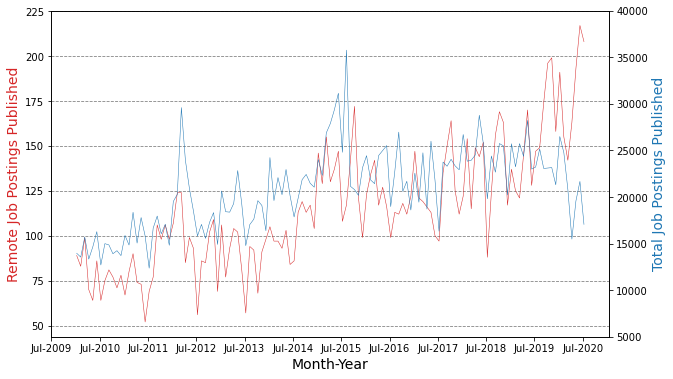

    Month-Year  Remote Postings Published  Postings Published
0     Jan-1970                        NaN                 NaN
1     Feb-1970                        NaN                 NaN
2     Mar-1970                        NaN                 NaN
3     Apr-1970                        NaN                 NaN
4     May-1970                        NaN                 NaN
..         ...                        ...                 ...
602   Mar-2020                      142.0             20809.0
603   Apr-2020                      163.0             15483.0
604   May-2020                      193.0             19568.0
605   Jun-2020                      217.0             21675.0
606   Jul-2020                      208.0             17063.0

[607 rows x 3 columns]


In [327]:
'''#Figure 1a shows the actual number of remote job postings on Jobindex at a given point in time in the period 2015-2020. 
The bars are further split into job categories (industries).'''
import matplotlib.pyplot as plt
import matplotlib.ticker

#Count the number of remote job postings per month-year with groupby
total_remote_date = pd.DataFrame(final_data.groupby('Month-Year')['Remote'].sum()).reset_index()
total_remote_date.columns = ['Month-Year','Remote Postings Published']

#Total number of job postings in the period
total_date = pd.read_pickle(path+'\Total_jobs_daily10-20.pkl')
total_date['Month-Year'] = pd.to_datetime(total_date['Date'], format='%Y%m%d').dt.to_period('M')
total_date['Month-Year'] = total_date['Month-Year'].dt.strftime('%b-%Y')
total_date = pd.DataFrame(total_date.groupby('Month-Year')['Postings Published'].sum()).reset_index()

#Merge all together
fig1a = pd.merge(months, total_remote_date, on='Month-Year', how='left')
fig1a = pd.merge(fig1a, total_date, on='Month-Year', how='left')
#remote_date.to_pickle(path+'xxx') #save the dataframe

#FIGURE 1a
fig,ax = plt.subplots(figsize=(10,6))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
ax.plot(fig1a['Month-Year'],fig1a['Remote Postings Published'], color=colors[3], linewidth=0.5)
# set x-axis label
ax.set_xlabel("Month-Year",fontsize=14)

# set y-axis label
ax.set_ylabel("Remote Job Postings Published",color=colors[3],fontsize=14)
ax.set_yticks(np.arange(50, 225+1, 25))

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(fig1a['Month-Year'],fig1a['Postings Published'],color=colors[0], linewidth=0.5)
ax2.set_ylabel("Total Job Postings Published",color=colors[0],fontsize=14)
#ticks
ax2.set_yticks(np.arange(5000, 40000+1, 5000))
start, stop = ax.get_xlim()
plt.xticks(np.arange(start, stop+1, 12), rotation=30)
#grid
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')

plt.show()
fig.savefig('fig1a.png')

print(fig1a)

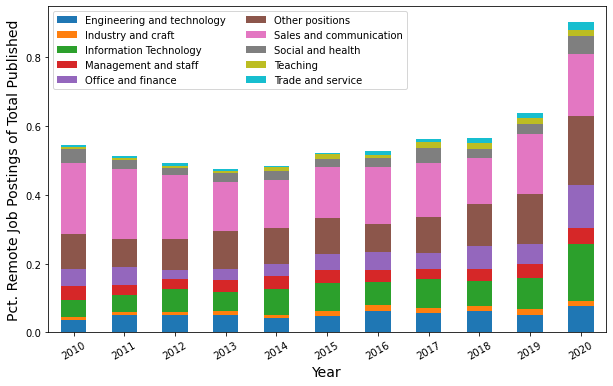

In [286]:
from matplotlib import colors as mcolors

'''#Figure 1b shows the percentage of remote job postings relative to the total number of job postings on Jobindex 
at a given point in time in the period 2015-2020. The bars are further split into job categories (industries).'''
#Make monthly data into year-level data
fig1a['Year'] = fig1a['Month-Year'].str.split('-', 1).str[1]
fig1b = pd.DataFrame(fig1a.groupby(['Year']).sum()).reset_index()

#Yearly total job postings
remote_category_year = pd.DataFrame(final_data.groupby(['Year','Job Category'])['Remote'].sum()).reset_index()
remote_category_year.columns = ['Year','Job Category','Remote Postings Published']
#print(remote_category_year)

#Merge
fig1b = pd.merge(remote_category_year, fig1b, on='Year', how='left')
fig1b['Pct. Remote Job Postings of Total Published'] = (fig1b['Remote Postings Published_x']/fig1b['Postings Published'])*100

#Stacked histogram
fig, ax = plt.subplots(figsize=(10,6))  
month = fig1b['Job Category'].drop_duplicates()
margin_bottom = np.zeros(len(fig1b['Year'].drop_duplicates()))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

for num, m in enumerate(month):
    values = list(fig1b[fig1b['Job Category'] == m].loc[:, 'Pct. Remote Job Postings of Total Published'])
    fig1b[fig1b['Job Category'] == m].plot.bar(x='Year',y='Pct. Remote Job Postings of Total Published', ax=ax, stacked=True, 
                                    bottom = margin_bottom, color=colors[num], label=m)
    margin_bottom += values
ax.set_xlabel('Year',fontsize=14)
ax.set_ylabel('Pct. Remote Job Postings of Total Published',fontsize=14)
plt.yticks(np.arange(0.0, 1.0, 0.2))
plt.xticks(rotation=30)
plt.legend(ncol=2)
plt.show()
fig.savefig('fig1b.png')


([<matplotlib.axis.XTick at 0x1ae9c01a5e0>,
 <a list of 355 Text major ticklabel objects>)

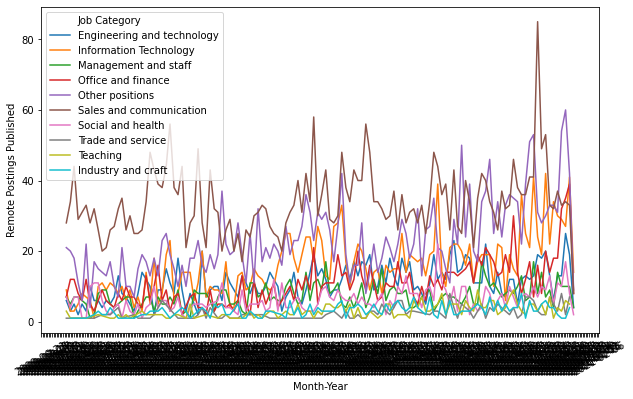

In [326]:
'''Figure 2 shows the trend in the total number of remote job postings in the different job categories.'''
'''#Count the number of remote job postings per area
fig2 = pd.DataFrame(final_data.groupby(['Month-Year','Job Category'])['Remote'].sum()).reset_index()
fig2.columns = ['Month-Year','Job Category','Remote Postings Published']
fig2['Month-Year'] = pd.to_datetime(fig2['Month-Year'], format='%b-%Y')

#Lineplot
fig, ax = plt.subplots(figsize=(10,6))  
ax = sns.lineplot(x="Month-Year", y="Remote Postings Published", hue="Job Category",data=fig2)
start, stop = ax.get_xlim()
plt.xticks(np.arange(start, stop+1, 12), rotation=30)'''



In [314]:
'''Table 1 shows the number of remote job postings in the top-10 and bottom-10 job subcategories in the years 2009 and 2020.'''
tb = pd.DataFrame(final_data.groupby(['Year','Job Subcategory'])['Remote'].sum()).reset_index()
tb.sort_values(['Year','Remote'], ascending=[True,False], inplace=True)

data2010 = tb[tb['Year'] == '2010']
data2010.sort_values(['Remote'], ascending=[False], inplace=True)
top10_2010 = data2010.head(10)
bottom10_2010 = data2010.tail(10)
print(top10_2010)
print(bottom10_2010)

data2020 = tb[tb['Year'] == '2020']
data2020.sort_values(['Remote'], ascending=[False], inplace=True)
top10_2020 = data2020.head(10)
bottom10_2020 = data2020.tail(10)
print(top10_2020)
print(bottom10_2020)

#print s.groupby(level=[0,1]).nlargest(1)

    Year           Job Subcategory  Remote
51  2010                 salg/salg     297
44  2010           oevrige/student     143
57  2010  social/socialraadgivning      35
45  2010     oevrige/studiepraktik      29
21  2010        it/systemudvikling      28
28  2010           kontor/oekonomi      28
19  2010                it/itdrift      23
11  2010     ingenioer/byggeteknik      22
38  2010    ledelse/projektledelse      21
37  2010         ledelse/personale      18
    Year                Job Subcategory  Remote
9   2010               industri/mekanik       1
10  2010               industri/tekstil       1
32  2010          ledelse/detailledelse       1
34  2010           ledelse/institutions       1
36  2010           ledelse/oekonomichef       1
40  2010             ledelse/topledelse       1
41  2010                   oevrige/elev       1
42  2010             oevrige/frivilligt       1
59  2010         undervisning/bibliotek       1
62  2010  undervisning/voksenuddannelse       1

<ipython-input-314-4e800e440e27>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2010.sort_values(['Remote'], ascending=[False], inplace=True)
<ipython-input-314-4e800e440e27>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2020.sort_values(['Remote'], ascending=[False], inplace=True)


In [325]:
'''Figure 3 shows the *number/percentage of remote job postings in different Danish regions in 2010, 2019 and 2020.'''

'''https://www.eea.europa.eu/data-and-maps/data/eea-reference-grids-2/gis-files/denmark-shapefile
    https://analyticsindiamag.com/beginners_guide_geographical_plotting_with_plotly/
    '''

#Count the number of remote job postings per month-year for each region
area_remote_year = pd.DataFrame(final_data.groupby(['Year','Geographical Area'])['Remote'].sum()).reset_index()
area_remote_year.columns = ['Year','Geographical Area','Remote Postings Published']
area_remote_year.sort_values(['Year','Remote Postings Published'], ascending=[True,False], inplace=True)
print(area_remote_year.head(8))



   Year   Geographical Area  Remote Postings Published
6  2010      storkoebenhavn                        404
3  2010  region-midtjylland                        176
4  2010  region-nordjylland                         88
1  2010                 fyn                         78
5  2010    region-sjaelland                         74
7  2010          sydjylland                         69
2  2010       nordsjaelland                         32
0  2010             danmark                         16


## Text Analysis

We begin by cleaning the snippets of job descriptions as much as possible by removing noisy terms such as symbols, numbers and stopwords. Part of this preprocessing also consists in separating the Danish and English job descriptions such that we can remove the relevant stop words for each language and also find the most common words for each language.

In [ ]:

final_data = pd.read_csv(r"C:\Users\lisbe\OneDrive\11. Semester\Social Data Science\Modules\final_data.csv", index_col=0).reset_index()
df = final_data.copy()

In [ ]:
# Removing job title and company info from the description column
# Detecting language
df['Language'] = ''
for i in range(len(df)):
    #df['Description'][i] = str(df['Description'][i]).replace(df['Job Title'][i],'')
    df['Description'][i] = str(df['Description'][i]).replace(df['Company'][i],'')
    df['Description'][i] = str(df['Description'][i]).strip()
    if len(df['Description'][i]) > 10:
        df['Language'][i] = detect(str(df['Description'][i]))
    else:
        df['Language'][i] = 'da'
        
# Some job postings were mistakenly classified as languages other than english or danish when they were actually danish:

for i in range(len(df)):
    if df['Language'][i] != 'da' and df['Language'][i] != 'en': 
        df['Language'][i] = 'da'

from nltk.stem.snowball import SnowballStemmer
stemmer_da = SnowballStemmer("danish")
stemmer_en = SnowballStemmer("english")

# Now we clean the descriptions as much as we can, tokenize them and stem them using the snowball stemmer
symbols = ['?','!','>','<','-','[',']','(',')','{','}',' –','``',"''",'""','\\','@','$','&','=']
useless_words = ['søger', 'vores', '.', 'kunder','jobcenter','arbejde','dine', 'får', 'samt', 'del','inden', 's', 'danmark','dit', 'både', 'ved','inden' ,'søges', 'a', 's', 'få', 'kan', 'så', 'opgaver',\
                 'jobsincopenhagen' ,'looking', 'denmark', 'work','company','eksiterende','spændende']
df['Tokenized_description'] = ''
for i in range(len(df)):
    stop_words_da = nltk.corpus.stopwords.words("danish")
    stop_words_en = nltk.corpus.stopwords.words("english")
    df['Tokenized_description'][i] = re.sub(r'(\.+ )|,|\||:|/|\'|\-|;|\*|!|(\s\d+\s)|(\s\W\s)',' ',str(df['Description'][i]))
    df['Tokenized_description'][i] = str(df['Tokenized_description'][i]).rstrip('\\')
    df['Tokenized_description'][i] = nltk.word_tokenize(str(df['Tokenized_description'][i].lower()))
    df['Tokenized_description'][i] = [w for w in df['Tokenized_description'][i] if not w in symbols]
    df['Tokenized_description'][i] = [w for w in df['Tokenized_description'][i] if not w.isnumeric()]
    df['Tokenized_description'][i] = [w for w in df['Tokenized_description'][i] if not w in useless_words]
    if df['Language'][i] == 'da':
        df['Tokenized_description'][i] = [w for w in df['Tokenized_description'][i] if not w in stop_words_da]
        #df['Tokenized_description'][i] = [stemmer_da.stem(w) for w in df['Tokenized_description'][i]]
    else:
        df['Tokenized_description'][i] = [w for w in df['Tokenized_description'][i] if not w in stop_words_en]
        #df['Tokenized_description'][i] = [stemmer_en.stem(w) for w in df['Tokenized_description'][i]]
        
# We split the datasets according to language
df_da = df[df['Language']=='da']
df_en = df[df['Language']=='en']
        
words_da_tok = df_da['Tokenized_description'].tolist()
words_en_tok = df_en['Tokenized_description'].tolist()

# Putting all words from all documents into the same list
flat_list_da = [item for sublist in words_da_tok for item in sublist] 
flat_list_en = [item for sublist in words_en_tok for item in sublist]

#Finding the most common words
from collections import Counter
top_en = Counter(flat_list_en).most_common(20)
top_da = Counter(flat_list_da).most_common(20)

In [ ]:
# Not sure this will be in use since we don't really need the matrix

from sklearn.feature_extraction.text import TfidfVectorizer

# Since we have already pre processed our data, we will use the vectorizer without it tokenizing our data
def dummy_fun(doc):
    return doc


tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None,
    max_df=0.95,
    min_df=0.04,
    max_features=10)  

vectors_da = tfidf.fit_transform(words_da_tok)
vocabulary_da = tfidf.vocabulary_
print(vocabulary_da)

vectors_den = tfidf.fit_transform(words_en_tok)
vocabulary_en = tfidf.vocabulary_
print(vocabulary_en)

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer()
bag = count.fit_transform(df['Tokenized_description'])
print(count.vocabulary_)

## Forecasting 

In [62]:
#conda install libpython m2w64-toolchain -c msys2
#pip install ephem
#pip install pystan
#pip install fbprophet

^C


In [73]:
# check prophet version
import fbprophet
# print version number
print('Prophet %s' % fbprophet.__version__)


Prophet 0.6
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
failed



Examining fbprophet: 100%|##########| 2/2 [00:00<00:00,  4.72it/s]
                                                                  

Examining conflict for python fbprophet:   0%|          | 0/2 [00:00<?, ?it/s]
                                                                              

UnsatisfiableError: The following specifications were found
to be incompatible with the existing python installation in your environment:

Specifications:

  - fbprophet -> python[version='2.7.*|3.5.*|3.6.*|>=2.7,<2.8.0a0|>=3.5,<3.6.0a0|>=3.6,<3.7.0a0|>=3.7,<3.8.0a0']

Your python: python=3.8

If python is on the left-most side of the chain, that's the version you've asked for.
When python appears to the right, that indicates that the thing on the left is somehow
not available for the python version you are constrained to. Note that conda will not
change your python version to a different minor version unless you explicitly specify
that.



